# 数据准备方向：让模型专注于注意到某种特征~
- 去除背景
- 只有人脸  

In [1]:
!ls /home/dell/workspace/xl_lora/zdx/

20230921-142228.jpeg  20230921-142302.jpeg  20230921-142319.jpeg
20230921-142251.jpeg  20230921-142306.jpeg  20230921-142322.jpeg
20230921-142257.jpeg  20230921-142310.jpeg


# 👏  1 rmbg 去除背景抠图~
- rembg i path/to/input.png path/to/output.png
- rembg i /home/dell/workspace/xl_lora/zdx/20230921-142228.jpeg /home/dell/workspace/xl_lora/zdxpure/20230921-142228.jpeg

In [109]:
import os
from PIL import Image
from rembg import remove
from PIL import Image

src = "/home/dell/workspace/xl_lora/zdx/"
target_dir = "/home/dell/workspace/xl_lora/zdxpure/"
target_face_dir = "/home/dell/workspace/xl_lora/zdxface/"

src_imgs = [src+i for i in os.listdir(src) if i.endswith(".jpeg")]
for i in src_imgs:
    break #   done
    img_name = i.split("/")[-1].replace("jpeg", "png")
    new_path = f"/home/dell/workspace/xl_lora/zdxpure/{img_name}"
    # rmbgcmd = f"rembg i {i} {new_path}"
    # os.popen(rmbgcmd).read()
    input = Image.open(i)
    output = remove(input)
    output.save(new_path)


In [115]:
jl_img = "./jl_test/jl_test.jpg"
new_path = "./jl_test/jl_test_pure.png"
input = Image.open(jl_img)
output = remove(input)
output.save(new_path)


# 👑 2 扣出人脸~

In [2]:
import cv2
import insightface
from insightface.app import FaceAnalysis
from insightface.data import get_image as ins_get_image

# faces[0].bbox 
import mediapipe as mp
from alian_face import mp_align_crop
mp_face_detection = mp.solutions.face_detection



# app = FaceAnalysis(name='buffalo_l')
# app.prepare(ctx_id=0, det_size=(640, 640))
# swapper = insightface.model_zoo.get_model('inswapper_128.onnx', download=True, download_zip=True)


2023-09-21 15:20:44.420383: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-21 15:20:44.422784: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-21 15:20:44.470273: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-09-21 15:20:44.471456: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-21 15:20:45.196921: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

In [5]:
src_imgs = [target_dir+i for i in os.listdir(target_dir) if i.endswith(".png")]
for i in src_imgs:
    src_img = i   #     '/home/dell/workspace/xl_lora/zdxpure/20230921-142228.jpeg'
    # img = Image.open(src_img)
    img = cv2.imread(src_img)  
    # faces = app.get(img)
    # faces = sorted(faces, key = lambda x : x.bbox[0])
    croped_aligned_face = mp_align_crop(src_img, mp_face_detection)
    img_name = src_img.split("/")[-1]  # .replace("jpeg", "png")
    new_path_crop = f"{target_face_dir}{img_name}"
    cv2.imwrite(new_path_crop, croped_aligned_face)
    
    
    


In [116]:
jl_img = "./jl_test/jl_test.jpg"
new_path = "./jl_test/jl_test_pure.png"
face_path = "./jl_test/jl_test_face.png"


croped_aligned_face = mp_align_crop(new_path, mp_face_detection)
cv2.imwrite(face_path, croped_aligned_face)



True

# 😅 3 训练lora
-    model_root = '/home/dell/workspace/models/stable-diffusion-xl-base-1.0'
-    output_dir = 'zdx'
-    device = 'cuda'
-    dtype = torch.float32
-    train_batch_size = 4
-    dataloader_num_workers = 2
-    with_prior_preservation = False
-    steps = 100
-    num_train_epochs = steps
-    gradient_accumulation_steps = 2
-    prompt = 'zdx'
-    resolution = 1024
-    mixed_precision = "bf16"
-    instance_data_dir = "/home/dell/workspace/xl_lora/zdxface"

In [9]:
~python xl_lora.py

(1440, 1080)

# 👑 4 加载lora测试~
- 7840efde04f4d505ae5dc46d3db25ca0  zdx/pytorch_lora_weights.safetensors

In [1]:
#  ---- 尝试load lora ，通过新的方式载入lora ------
import torch
from diffusers import StableDiffusionXLPipeline

xl_model_cfg = {
    'base': '/home/dell/workspace/models/stable-diffusion-xl-base-1.0',
    "zdx_xl_lora": '/home/dell/workspace/xl_lora/zdx/pytorch_lora_weights.safetensors',
    "jl_xl_lora": '/home/dell/workspace/xl_lora/zdx/pytorch_lora_weights.safetensors',
}

device = "cuda"
dtype = torch.float16


model_path = "./zdxface/checkpoint-500/pytorch_lora_weights.safetensors"
pipexl = StableDiffusionXLPipeline.from_pretrained(xl_model_cfg["base"], torch_dtype=torch.float16, use_safetensors=True, variant="fp16")
pipexl.unet.load_attn_procs(model_path)
# pipexl.vae.enable_tiling()
# pipexl.vae.enable_slicing()

pipexl = pipexl.to("cuda")
# pipexl.load_lora_weights(model_path)



2023-09-28 15:19:00.252135: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-09-28 15:19:00.306130: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-09-28 15:19:01.208673: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

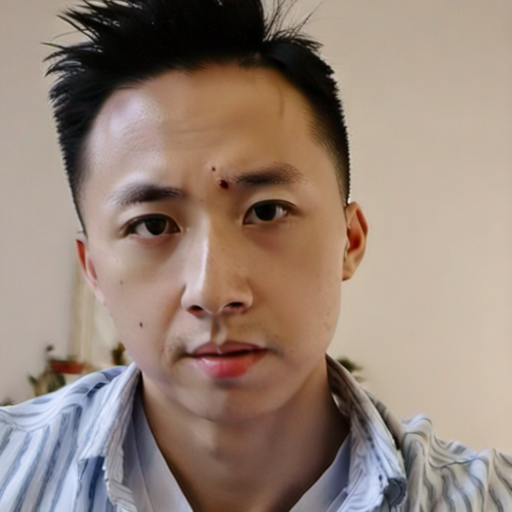

In [49]:
prompt = "a man,in tower of pairs"  # 生成内容
prompt = "zdx, in seaside"  # 生成内容
image = pipexl(prompt, num_inference_steps=20, guidance_scale=7.5, height=768, width=768).images[0]
# image.save("moose.png")  # 保存图像名

image.resize(size=(512, 512))

In [41]:
jl_lora = "./jlout/pytorch_lora_weights.safetensors"
jl_lora = "./jlout/jl_lora_weights.safetensors"       
# --   上面的用load_attn_procs(jl_lora) 处理
# ----------------------- 下面的使用mix_lora 处理 ----------------
jl_lora = "/home/dell/workspace/kohya_ss/output/jl_out-step00000100.safetensors"  # koha loray sdxl
pipexl.unload_lora_weights()
# pipexl.unet.load_attn_procs(jl_lora)

In [42]:
pipexl.load_lora_weights(jl_lora)

  0%|          | 0/20 [00:00<?, ?it/s]

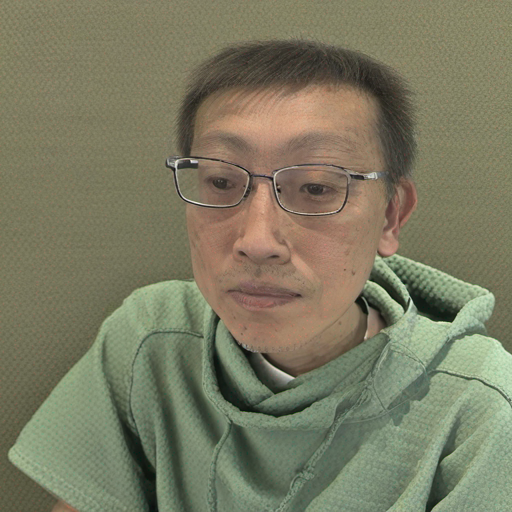

In [51]:
prompt = "jl"  # 生成内容

image = pipexl(prompt, num_inference_steps=20, guidance_scale=7.5, height=768, width=768).images[0]

image.resize(size=(512, 512))

# 👑 4 换脸 

In [ ]:
# img = ins_get_image()
src_img = '/Users/zdx/Desktop/WechatIMG9305.jpg'
src_img = cv2.imread(src_img)  
srcfaces = app.get(src_img)
srcfaces = sorted(srcfaces, key = lambda x : x.bbox[0])

tar_img = '/Users/zdx/Desktop/seaside_girl.png'
tar_img = cv2.imread(tar_img)   
faces = app.get(tar_img)
faces = sorted(faces, key = lambda x : x.bbox[0])
